In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import json
import numpy as np
import tensorflow as tf

IMG_DIR = 'files/images-2cat'

Take a look at my poor little GPU ¯\\_(ツ)_/¯

In [2]:
from subprocess import Popen, PIPE

process = Popen(['nvidia-smi'], stdout=PIPE)
(output, err) = process.communicate()
exit_code = process.wait()
print(output.decode('utf8'))

Thu Dec  9 22:29:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   44C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
seed = 666
image_size = (256, 256)
# Size to resize images to after they are read from disk.
# Defaults to (256, 256). Since the pipeline processes batches
# of images that must all have the same size, this must be provided. 
batch_size = 2

validation_split=0.33
# float between 0 and 1, fraction of data to reserve for validation. 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_DIR,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_DIR,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6531 files belonging to 2 classes.
Using 4376 files for training.
Found 6531 files belonging to 2 classes.
Using 2155 files for validation.


In [5]:
# Visualize the data
#import matplotlib.pyplot as plt

#plt.figure(figsize=(20, 10))
#for images, labels in train_ds.take(1):
#    for i in range(8):
#        ax = plt.subplot(1, 4, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(int(labels[i]))
#        plt.axis("off")

In [6]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    #x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.Activation("relu")(x)

    x = layers.Dense(128, activation="ReLU")(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 dense_4 (Dense)             (None, 256, 256, 128)     512       
                                                                 
 global_average_pooling2d_1   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_____________________________________________________________

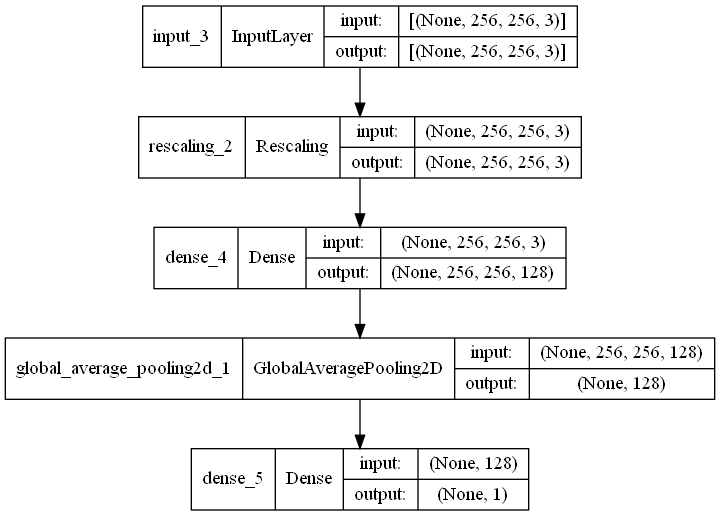

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
2188/2188 [==============================] - 117s 53ms/step - loss: 0.5654 - accuracy: 0.7505 - val_loss: 0.5779 - val_accuracy: 0.7318
Epoch 2/5
2188/2188 [==============================] - 117s 54ms/step - loss: 0.5604 - accuracy: 0.7509 - val_loss: 0.5756 - val_accuracy: 0.7318
Epoch 3/5
2188/2188 [==============================] - 118s 54ms/step - loss: 0.5575 - accuracy: 0.7509 - val_loss: 0.5738 - val_accuracy: 0.7318
Epoch 4/5
2188/2188 [==============================] - 119s 54ms/step - loss: 0.5552 - accuracy: 0.7509 - val_loss: 0.5726 - val_accuracy: 0.7318
Epoch 5/5
2188/2188 [==============================] - 119s 54ms/step - loss: 0.5533 - accuracy: 0.7509 - val_loss: 0.5702 - val_accuracy: 0.7318
